# 01_Calibration 

developed by SSA for calibration before moving onto diffraction sorting 


In [2]:
#imports and paths 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import fabio 
import h5py 

from scipy.ndimage import median_filter 
from pyFAI.integrator.azimuthal import AzimuthalIntegrator 


In [3]:
#laoding the calibration files 
base_dir = r"D:/I11 Beamtime July/" #load your directory - remember directory needs "/" not "\" and a "/" on the end to be read correctly 
calib_hdf = os.path.join(base_dir, "pixium_107899_Calib_KAP.hdf") #hdf = name of calibration file 

#after calibration, the poni and mask will be saved here 
out_dir = base_dir 
poni_out = os.path.join(out_dir, "i11_calib_KAP_CeO2.poni")
mask_out = os.path.join(out_dir, "hot_pixel_mask_KAP.npy")


In [4]:
#robust loader - trials the fabio interface first but has h5py searching as a fallback 
def load_image_any(path):
    """Load a single 2D image froma file. Try Fabio first; if not, inspect HDF5."""
    path = os.path.abspath(path)

    #try fabio
    try:
        im = fabio.open(path)
        data = im.data.astype(np.float32)
        print(f"Loaded via fabio: {path} shape={data.shape}")
        return data 

    except Exception as e:
        print("fabio failed:", e, " - trying h5py fallback for HDF/nexus.")
    #try h5py: find a 2D dataset 

    with h5py.File(path, "r") as f:
        datasets = []
        def visitor(name, obj):
            try:
                if isinstance(obj, h5py.Dataset) and obj.ndim ==2:
                    datasets.append(name)
            except Exception:
                pass
        f.visititems(visitor)
        if not datasets:
            raise RuntimeError(f"no 2D dataset dound in {path} (checked with h5py).")
        #pick the first 2D dataset (usually correct for calibration images) 
        ds = datasets[0]
        data = f[ds][()].astype(np.float32)
        print(f"loaded via h5py dataset: {ds} shape={data.shape}")
        return data 
    
            


Loaded via fabio: D:\I11 Beamtime July\pixium_107899_Calib_KAP.hdf shape=(2881, 2880)


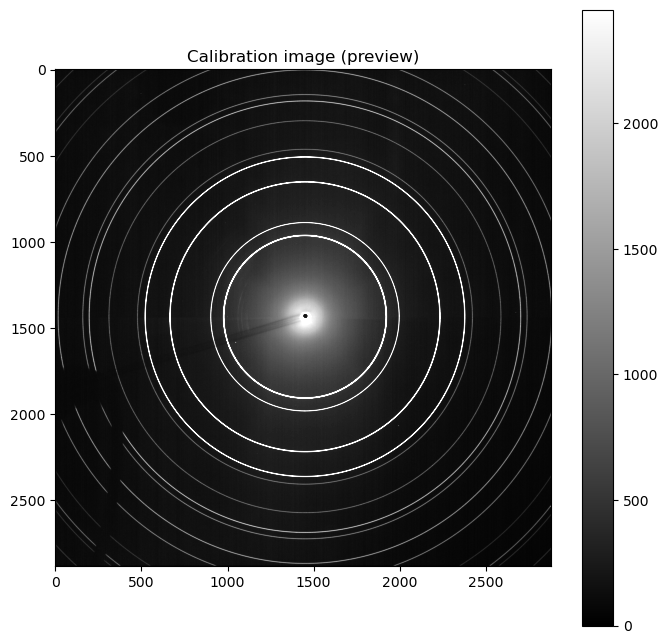

In [5]:
#load and show calibration image 
img = load_image_any(calib_hdf)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray", vmax=np.percentile(img,99))
plt.title("Calibration image (preview)")
plt.colorbar()
plt.show()

In [8]:
#run the pyFAI GIU for interactive calibration
print("\nNow run the pyFAI GUI to pick rings and save a .poni file.")
print("From a terminal (with same conda env) run:  pyfai-calib2 \"{}\"".format(calib_hdf))
print("Or from Jupyter you can run:  !pyfai-calib2 \"{}\"".format(calib_hdf))
print("In the GUI: choose calibrant (CeO2), click rings, adjust fit, then Export/save .poni and optionally save mask.\n")


#now run pyfai-calib2 and save poni file 
# if poni file already attained, point poni_path to it 
poni_path = os.path.join(out_dir, "calib_kap.poni") #update if gui set to save as another file name 



Now run the pyFAI GUI to pick rings and save a .poni file.
From a terminal (with same conda env) run:  pyfai-calib2 "D:/I11 Beamtime July/pixium_107899_Calib_KAP.hdf"
Or from Jupyter you can run:  !pyfai-calib2 "D:/I11 Beamtime July/pixium_107899_Calib_KAP.hdf"
In the GUI: choose calibrant (CeO2), click rings, adjust fit, then Export/save .poni and optionally save mask.



In [9]:
#scarlett adapted code
#load the .poni file 

ai = None
if os.path.exists(poni_path): 
    try:
        # Two ways depending on pyFAI version
        ai = AzimuthalIntegrator(poni_file=poni_path)
    except Exception:
        try:
            ai = AzimuthalIntegrator()
            ai.load(poni_path)
        except Exception as e:
            print("Failed to load .poni automatically:", e)
   # else:
    #    print("loaded .poni", poni_path)
     #   print("Detector distance (m):", ai.dist, "  beam center px:", ai.poni1, ai.poni2)
    if ai is not None and ai.dist is not None:
        print(f"Successfully loaded .poni: {poni_path}")
        print(f"   Detector distance (m): {ai.dist:.4f}")
        print(f"   Beam center (px): poni1={ai.poni1:.2f}, poni2={ai.poni2:.2f}")
    else:
        print("poni file was found but integrator looks empty — check file validity.")
else:
    print("No .poni found yet at:", poni_path)
    print("Run the GUI and save the .poni, then re-run this cell (or set poni_path).")


Successfully loaded .poni: D:/I11 Beamtime July/calib_kap.poni
   Detector distance (m): 0.4362
   Beam center (px): poni1=0.21, poni2=0.21


No frame_sized found — building mask from the calibration image preview.
Built mask with percentile 99.9 -> threshold 11123.7; #hot pixels = 8298
Saved mask to: D:/I11 Beamtime July/hot_pixel_mask_KAP.npy


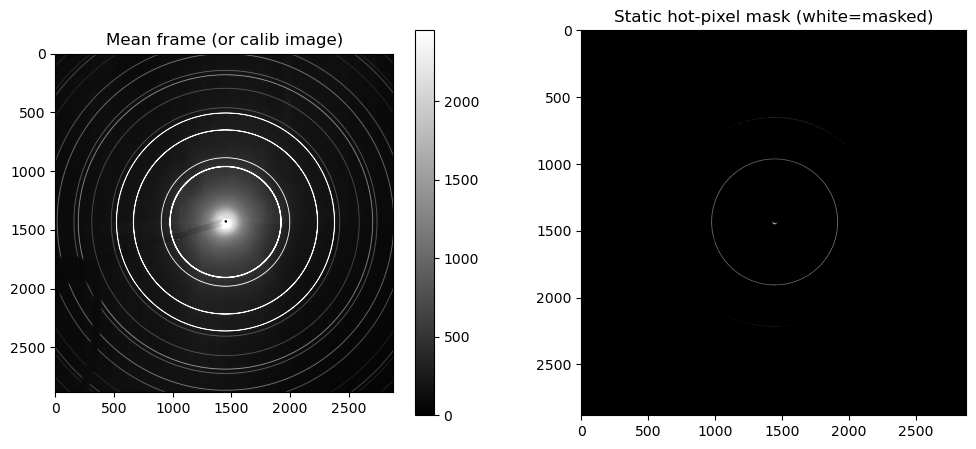

In [10]:
# Build / load static hot-pixel mask 
# This code may need to be developed further - 29.09.2025
#scarlett code
combined_mask = None
mean_frame = None  # define so it's always available

if os.path.exists(mask_out):
    combined_mask = np.load(mask_out)
    print("Loaded existing mask:", mask_out, "mask shape:", combined_mask.shape)

    # try to also load/create a mean_frame for plotting
    try:
        frame_sized  # noqa
        mean_frame = np.mean(frame_sized, axis=0)
    except NameError:
        mean_frame = img  # fallback if only calibration image is available
        print("No frame_sized found — using calibration image as mean_frame for plotting.")

else:
    # Build new mask
    try:
        frame_sized  # noqa
        mean_frame = np.mean(frame_sized, axis=0)
        print("Built mask from existing frame_sized (mean across frames).")
    except NameError:
        mean_frame = img  # fallback
        print("No frame_sized found — building mask from the calibration image preview.")
    
    hot_pct = 99.9
    hot_threshold = np.percentile(mean_frame.ravel(), hot_pct)
    combined_mask = mean_frame > hot_threshold
    print(f"Built mask with percentile {hot_pct} -> threshold {hot_threshold:.1f}; #hot pixels = {combined_mask.sum()}")
    np.save(mask_out, combined_mask)
    print("Saved mask to:", mask_out)

# --- Show the mask and mean image
if mean_frame is not None:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(mean_frame, cmap="gray", vmax=np.percentile(mean_frame,99))
    plt.title("Mean frame (or calib image)")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(combined_mask, cmap="gray")
    plt.title("Static hot-pixel mask (white=masked)")
    plt.show()
else:
    print("Warning: mean_frame could not be built, so no plot will be shown.")


Despike complete: 11507 pixels replaced (size=3, sigma=8)


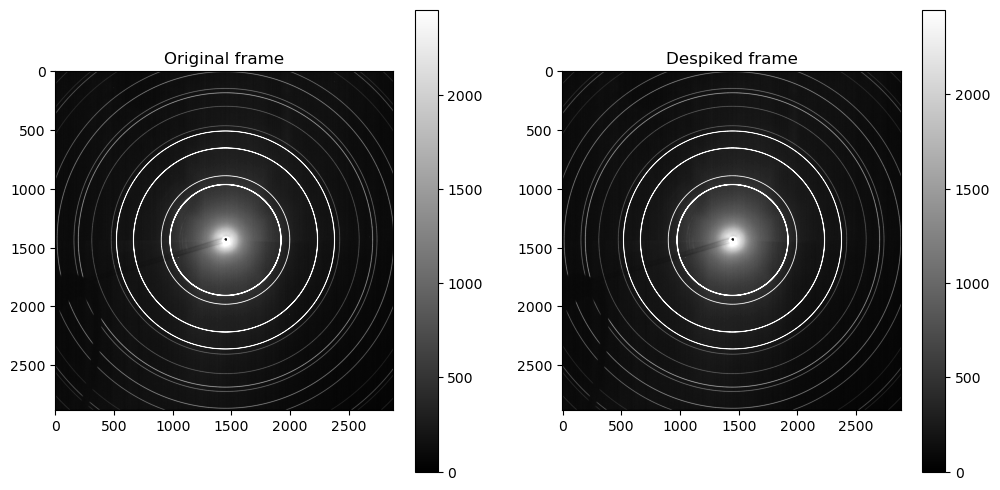

In [11]:
# optional: despike function for transient hot pixels 
#scarlett code 
def despike_frame_local(frame, size=3, thresh_sigma=8, verbose=True):
    """
    Replace isolated bright pixels that exceed local median + thresh_sigma*sigma_est.
    Returns the cleaned frame.
    """
    local_med = median_filter(frame, size=size)
    mad = np.median(np.abs(frame - np.median(frame)))
    sigma_est = 1.4826 * mad
    mask = (frame - local_med) > (thresh_sigma * sigma_est)
    
    frame_clean = frame.copy()
    frame_clean[mask] = local_med[mask]
    
    n_changed = np.sum(mask)
    if verbose:
        print(f"Despike complete: {n_changed} pixels replaced (size={size}, sigma={thresh_sigma})")
    
    return frame_clean

# Example usage on calibration image (or one frame)
test_clean = despike_frame_local(img, size=3, thresh_sigma=8)

# Visual check
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray', vmax=np.percentile(img,99))
plt.title("Original frame")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(test_clean, cmap='gray', vmax=np.percentile(test_clean,99))
plt.title("Despiked frame")
plt.colorbar()
plt.show()



In [12]:
# function: compute k-th largest intensity per frame (masked, memory-efficient)
def kth_largest_per_frame(frames, mask, k=5, use_despike=False, despike_kwargs=None):
    """
    frames: array-like with shape (n_frames, H, W) OR an iterable of 2D arrays
    mask: boolean array shape (H,W) where True means BAD (masked out)
    Returns: 1D np.array of length n_frames (k-th largest intensity among unmasked pixels)
    """
    if despike_kwargs is None:
        despike_kwargs = {}
    # ensure mask is boolean
    mask_bool = np.asarray(mask, dtype=bool)
    out = []
    # handle both numpy array input and generator/iterable
    for i, frame in enumerate(frames):
        f = frame.copy()
        if use_despike:
            f = despike_frame_local(f, **despike_kwargs)
        valid = f[~mask_bool].ravel()
        if valid.size == 0:
            out.append(np.nan)
            continue
        # if not enough pixels, just take max:
        if valid.size <= k:
            out.append(valid.max())
        else:
            # np.partition gets the k-th largest quickly; we take the k-th largest value
            # note: -k gives the k largest elements at the end; take min of those = k-th largest
            idx = np.argpartition(valid, -k)[-k:]
            kth_val = valid[idx].min()
            out.append(kth_val)
    return np.array(out)


In [13]:
# Example: apply to your dataset 
# If you already have frame_sized loaded (n_frames, H, W), run:
try:
    n_frames = frame_sized.shape[0]
    print("Using existing frame_sized with", n_frames, "frames.")
    pixel_intensity_no = 5
    # compute k-th values masked (no despike)
    pixel_values_masked = kth_largest_per_frame(frame_sized, combined_mask, k=pixel_intensity_no, use_despike=False)
    print("Computed pixel values (masked) for {} frames.".format(len(pixel_values_masked)))
except NameError:
    print("frame_sized not found in this notebook. If you have your dataset loaded, run:")
    print("  pixel_values_masked = kth_largest_per_frame(frame_sized, combined_mask, k=5)")

frame_sized not found in this notebook. If you have your dataset loaded, run:
  pixel_values_masked = kth_largest_per_frame(frame_sized, combined_mask, k=5)


In [ ]:
# quick calibrated integrate1d check (if .poni loaded) 
if ai is not None:
    # pick a frame (either img from calib or frame_sized[0])
    if 'frame_sized' in globals():
        test_frame = frame_sized[0]
    else:
        test_frame = img
    npt = 1500
    try:
        # newer pyFAI return object or tuple; handle both:
        res = ai.integrate1d(test_frame.astype(np.float32), npt, mask=combined_mask, unit="2th_deg")
        # try to extract radial & intensity
        try:
            # pyFAI >= 1.0 maybe returns an object with .radial and .intensity
            radial = res.radial
            intensity = res.intensity
        except Exception:
            # fallback: assume tuple (radial, intensity, std)
            radial = res[0]
            intensity = res[1]
        plt.figure(figsize=(6,4))
        plt.plot(radial, intensity)
        plt.xlabel("2θ (deg)")
        plt.ylabel("Intensity")
        plt.title("Integrated 1D (masked) - test frame")
        plt.show()
    except Exception as e:
        print("integrate1d failed (pyFAI version mismatch?). Error:", e)
        print("If this fails, you can still use the .poni in your later analysis when calling ai.integrate1d() with the mask.")
else:
    print("No AzimuthalIntegrator loaded (poni not found).")

In [ ]:
#save mask and (optionally) pixel values
np.save(mask_out, combined_mask)
print("Mask saved to:", mask_out)
if 'pixel_values_masked' in locals():
    np.save(os.path.join(out_dir, "pixel_values_masked_k{}.npy".format(pixel_intensity_no)), pixel_values_masked)
    print("Saved pixel values masked.")